In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
#Read genome sequence file

genome_sequence = ''
with open('NC_011297.fna', 'r') as f :
    f.readline()
    
    for line in f :
        genome_sequence += line.strip()

print('genome length = ' + str(len(genome_sequence)))

genome length = 1959987


In [11]:
#Problem 2.1 - 2.2
states = ['AT', 'GC']
nucleotides = ['A', 'C', 'G', 'T']
    
#Takes as input the emission sequence (genome) and probability parameters
#Outputs the most likely state sequence using Viterbi decoding
def viterbi_decode(emissions, init_prob, trans_prob, emission_prob) :
    #TODO: Implement the Viterbi decoding algorithm
    #Store the decoded state sequence in 'max_states'
    #Store the state sequence log likelihood in 'max_states_logprob'
    T = len(emissions)
    
    max_states_logprob = 0
    max_states = [0] * T
    
    init_log_prob = np.log(init_prob)
    trans_log_prob = np.log(trans_prob)
    emission_log_prob = np.log(emission_prob)
    
    v = np.zeros((T + 1, len(states)))
    bp = np.zeros((T + 1, len(states)))
    v.fill(float("-inf"))  

    v[0] = init_log_prob
    
    for i in np.arange(1, T + 1):
        nucleotide = nucleotides.index(emissions[i - 1])
        for j in range(len(states)):
            for k in range(len(states)):
                vij = emission_log_prob[j][nucleotide] + v[i - 1][k] + trans_log_prob[k][j]
                if vij > v[i][j]:
                    v[i][j] = vij
                    bp[i][j] = k
    max_states[T - 1] = np.argmax(v[T])
    max_states_logprob = np.max(v[T])
    for i in np.arange(T - 2, -1, -1):
        max_states[i] = int(bp[i + 1][max_states[i + 1]])
    #max_states_labels = [states[i] for i in max_states]
    return max_states_logprob, max_states

#Takes as input the emission sequence (genome) and probability parameters
#Outputs new (re-estimated) probability parameters
def viterbi_train(emissions, init_prob, trans_prob, emission_prob, n_iter=10) :

    log_probs = []
    new_trans_prob = np.copy(trans_prob)
    new_emission_prob = np.copy(emission_prob)
    
    #TODO: Implement Viterbi training to re-estimate parameters
    #Store the new parameters in the 'new_' matrices
    #Store the Viterbi-decoded state sequence log likelihood in 'log_probs' at each iteration of training
    for i in range(n_iter):
        print(f'Running iteration {i}')
        # estimation
        log_prob, prob_states = viterbi_decode(emissions, init_prob, new_trans_prob, new_emission_prob)
        log_probs.append(log_prob)
        
        # maximization
        # count emissions and state transitions
        cts_init_prob = np.zeros(init_prob.shape)
        cts_prev_prob = np.zeros(init_prob.shape)
        cts_trans_prob = np.zeros(new_trans_prob.shape)
        cts_emission_prob = np.zeros(new_emission_prob.shape)
        prev_state = None
        
        for j in range(len(emissions)):
            nucleotide = nucleotides.index(emissions[j])
            curr_state = prob_states[j]
            if prev_state != None:
                cts_prev_prob[prev_state] += 1
                cts_trans_prob[prev_state][curr_state] += 1
            cts_emission_prob[curr_state][nucleotide] += 1
            cts_init_prob[curr_state] += 1
            
            prev_state = curr_state
        
        # normalize the new probabilites
        new_emission_prob[0] = cts_emission_prob[0] / cts_init_prob[0]
        new_emission_prob[1] = cts_emission_prob[1] / cts_init_prob[1]
        new_trans_prob[0] = cts_trans_prob[0] / cts_prev_prob[0]
        new_trans_prob[1] = cts_trans_prob[1] / cts_prev_prob[1]
        
    return log_probs, new_trans_prob, new_emission_prob


In [12]:
#Problem 2.1
#Here we initialize the probability matrices for the HMM

#TODO: Initialize P(s_{1})
init_state = np.array([0.996, 0.004])

#TODO: Initialize P(s_{t} | s_{t-1})
init_trans = np.array([
    [0.999, 0.001], #s_{t-1} = AT
    [0.01, 0.99] #s_{t-1} = GC
])

#TODO: Initialize P(o_{t} | s_{t})
init_emission = np.array([
    [0.291, 0.209, 0.209, 0.291], #s_{t} = AT
    [0.169, 0.331, 0.331, 0.169] #s_{t} = GC
])


In [13]:
#Problem 2.1
#TODO: Run Viterbi decoding to obtain the most likely state sequence for the genome
max_end_logprob, prob_states = viterbi_decode(genome_sequence, init_state, init_trans, init_emission)
print('max end log probability: ' + str(max_end_logprob))

max end log probability: -2640006.4047375


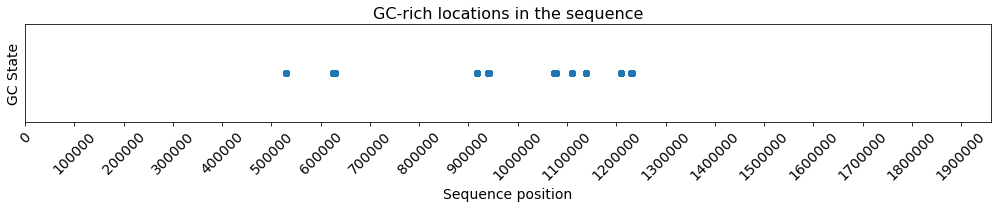

In [14]:
#Problem 2.1
#TODO: Plot the genomic nucleotide coordinates of detected GC-rich regions
f = plt.figure(figsize=(14, 3))
states_nonzero = np.nonzero(prob_states)
plt.scatter(states_nonzero[0], np.zeros(len(states_nonzero[0])))
plt.title("GC-rich locations in the sequence", fontsize=16)
plt.xlabel('Sequence position', fontsize=14)
plt.ylabel('GC State', fontsize=14)
plt.xticks(np.arange(0, len(prob_states), step=100000), rotation=45, fontsize=14)
plt.yticks([], [])

plt.xlim(0, len(prob_states))

plt.tight_layout()
plt.show()

Running iteration 0
Running iteration 1
Running iteration 2
Running iteration 3
Running iteration 4
Running iteration 5
Running iteration 6
Running iteration 7
Running iteration 8
Running iteration 9
Running iteration 10
Final log probability : [-2640006.4047375, -2609769.029677031, -2609763.3187226583, -2609763.3432755275, -2609763.3432755275, -2609763.3432755275, -2609763.3432755275, -2609763.3432755275, -2609763.3432755275, -2609763.3432755275, -2609763.3432755275]


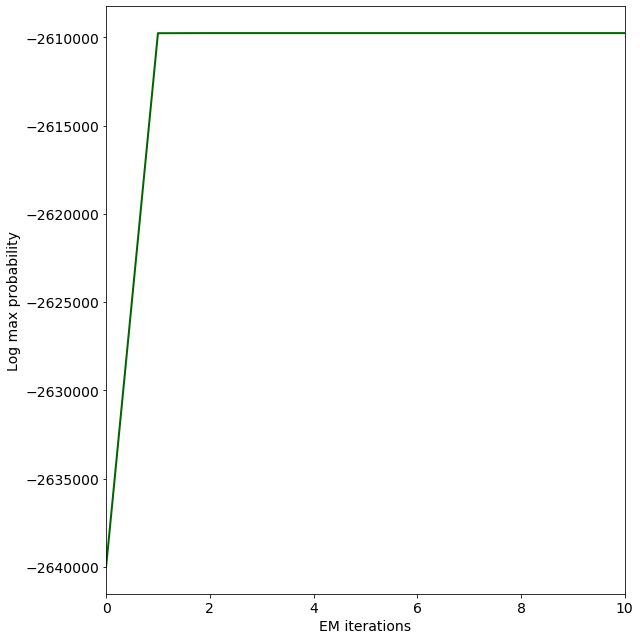

max end log probabilities: -2609763.3432755275


In [25]:
#Problem 2.2
new_log_probs, new_trans_prob, new_emission_prob = viterbi_train(genome_sequence, init_state, init_trans, init_emission, n_iter=11)

print(f'Final log probability : {new_log_probs}')

f = plt.figure(figsize=(9, 9))

plt.plot(np.arange(len(new_log_probs)), new_log_probs, linewidth=2, c='darkgreen')

plt.xlabel('EM iterations', fontsize=14)
plt.ylabel('Log max probability', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, len(new_log_probs) - 1)

plt.tight_layout()
plt.show()


#Problem 2.2
new_max_end_logprob, new_prob_states = viterbi_decode(genome_sequence, init_state, new_trans_prob, new_emission_prob)
print('max end log probabilities: ' + str(new_max_end_logprob))

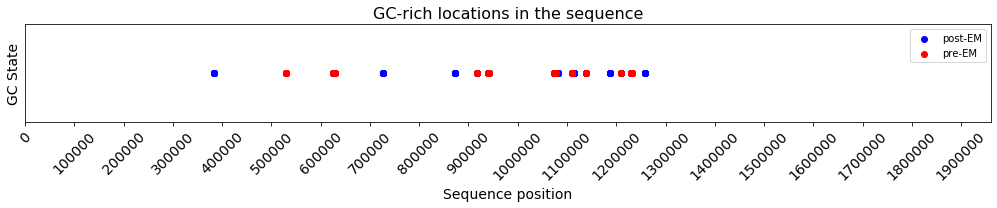

In [27]:
#Problem 2.2
#TODO: Plot the genomic coordinates of newly detected GC-rich regions along with the previous detected regions
f, ax = plt.subplots(figsize=(14, 3))
new_states_nonzero = np.nonzero(new_prob_states)
plt.scatter(new_states_nonzero[0], np.zeros(len(new_states_nonzero[0])), c='b', label='post-EM')
plt.scatter(states_nonzero[0], np.zeros(len(states_nonzero[0])), c='r', label='pre-EM')
plt.title("GC-rich locations in the sequence", fontsize=16)
plt.xlabel('Sequence position', fontsize=14)
plt.ylabel('GC State', fontsize=14)
plt.xticks(np.arange(0, len(new_prob_states), step=100000), rotation=45, fontsize=14)
plt.yticks([], [])

ax.legend()
plt.xlim(0, len(new_prob_states))

plt.tight_layout()
plt.show()

In [ ]:
#Problem 2.2
#TODO: Plot the genomic coordinates of newly detected GC-rich regions along with the previous detected regions
f, ax = plt.subplots(figsize=(14, 3))
new_states_nonzero = np.nonzero(new_prob_states)
plt.scatter(new_states_nonzero[0], np.zeros(len(new_states_nonzero[0])), c='b', label='post-EM')
plt.scatter(states_nonzero[0], np.ones(len(states_nonzero[0])), c='r', label='pre-EM')
plt.title("GC-rich locations in the sequence", fontsize=16)
plt.xlabel('Sequence position', fontsize=14)
plt.ylabel('GC State', fontsize=14)
plt.xticks(np.arange(0, len(new_prob_states), step=100000), rotation=45, fontsize=14)
plt.yticks([], [])

ax.legend()
plt.xlim(0, len(new_prob_states))

plt.tight_layout()
plt.show()

In [26]:
print(len(new_prob_states))

1959987
